This notebook is used for comparing baseline evaluations with Hegre et. al.'s original predictions

In [23]:
import numpy as np
import pandas as pd
import country_converter as coco
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
cc = coco.CountryConverter()

Read in Data, Pre-process for Standardization

In [24]:
actual_outcomes = pd.read_csv("../data/Analysis/data/tables/acd.csv") 

# pick relevant years
# ground_truth = actual_outcomes[(actual_outcomes["year"] >= 2001) & (actual_outcomes["year"]<= 2018)]
ground_truth = actual_outcomes


hegre_preds_2001_2009 = pd.read_csv("../data/Analysis/data/tables/predictions_2001_2009.csv")

# Load the second CSV file
hegre_preds_2010_2050 = pd.read_csv("../data/Analysis/data/tables/predictions_2010_2050.csv")

# Concatenate the two DataFrames into one
hegre_preds = pd.concat([hegre_preds_2001_2009, hegre_preds_2010_2050], axis=0).reset_index(drop=True)

# hegre_preds["gwcode"] = hegre_preds["gwcode"].astype(int)
# hegre_preds['alpha3'] = cc.pandas_convert(series=hegre_preds.gwcode, to='ISO3', src='gwcode')
# hegre_preds = hegre_preds[hegre_preds.alpha3 != 'not found']
# hegre_preds['un_region'] = cc.pandas_convert(series=hegre_preds.alpha3, to='UNREGION', src='ISO3')
# hegre_preds
hegre_preds = hegre_preds.rename(columns={'minor':'prob_minor', 'major':'prob_major'})
baseline_1970_2000 = pd.read_csv("predictions_baseline_1970_2000.csv")
baseline_1970_2000 = baseline_1970_2000.rename(columns={'Year':'year'})
baseline_1992_2000 = pd.read_csv("predictions_baseline_1992_2000.csv")
baseline_1992_2000 = baseline_1992_2000.rename(columns={'Year':'year'})
baseline_naive = pd.read_csv("predictions_baseline_naive.csv")
baseline_naive = baseline_naive.rename(columns={'Year':'year'})

In [25]:
# Takes in the ground_truth dataframe and predictions, and outputs an evaluation dataframe
# merged on country-years, and with true negatives filled in
def make_eval_df(preds: pd.DataFrame, ground_truth: pd.DataFrame) -> pd.DataFrame:
    # Create a DataFrame with all unique country-year pairs from both DataFrames
    # preds has columns gwcode, year, minor, major
    all_country_years = pd.concat([
        preds[['gwcode', 'year']].drop_duplicates(),
        ground_truth[['gwcode', 'year']].drop_duplicates()
    ]).drop_duplicates().reset_index(drop=True)

    # Update the ground truth to include all country-years, filling missing values with 0
    all_ground_truth = pd.merge(all_country_years, ground_truth, on=['gwcode', 'year'], how='left').fillna(0)

    # Merge this updated ground truth with the predictions DataFrame
    eval_df = pd.merge(hegre_preds, all_ground_truth, on=['gwcode', 'year'])

    return eval_df

In [26]:
# Call make_eval_df function
hegre_eval = make_eval_df(hegre_preds, ground_truth)
baseline_1970_2000_eval = make_eval_df(baseline_1970_2000, ground_truth)
baseline_1992_2000_eval = make_eval_df(baseline_1992_2000, ground_truth)
baseline_naive_eval = make_eval_df(baseline_naive, ground_truth)

In [27]:
# fig, ax = plt.subplots(figsize=(7,7)) # You can adjust the size as needed
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
#             xticklabels=['Predicted 0', 'Predicted 1'],
#             yticklabels=['Actual 0', 'Actual 1'])
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')
# plt.title('Confusion Matrix')
# plt.show()

Metric Calculation

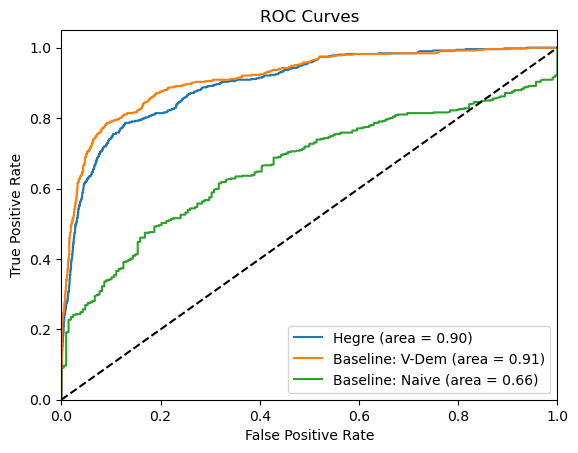

In [29]:
fpr_1, tpr_1, _ = roc_curve(hegre_eval['either_actual'], hegre_eval[['prob_minor', 'prob_major']].max(axis = 1))
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(baseline_1970_2000_eval['either_actual'], baseline_1970_2000_eval[['prob_minor', 'prob_major']].max(axis = 1))
roc_auc_2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, _ = roc_curve(baseline_naive_eval['either_actual'], baseline_naive_eval[['prob_minor', 'prob_major']].max(axis = 1))
roc_auc_3 = auc(fpr_3, tpr_3)

# Plot all ROC curves
plt.figure()
plt.plot(fpr_1, tpr_1, label='Hegre (area = %0.2f)' % roc_auc_1)
plt.plot(fpr_2, tpr_2, label='Baseline: V-Dem (area = %0.2f)' % roc_auc_2)
plt.plot(fpr_3, tpr_3, label='Baseline: Naive (area = %0.2f)' % roc_auc_3)

plt.plot([0, 1], [0, 1], 'k--')  # Draw the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

ROC AUC (Minor Conflict): 0.8981983435811033


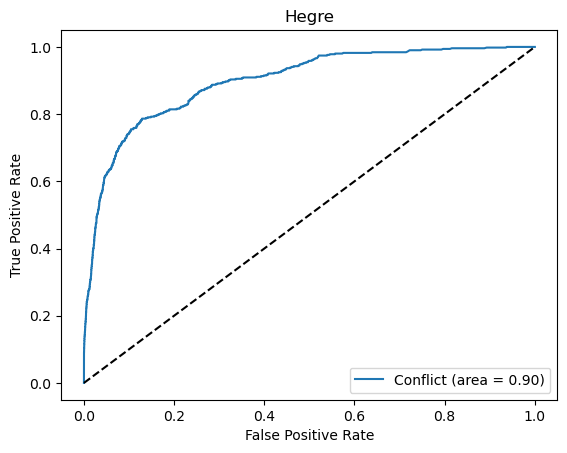

In [19]:
# For ROC AUC and ROC Curve, you need the probabilities, not the binary predictions
y_true = hegre_eval['either_actual']
y_prob= hegre_eval[['prob_minor', 'prob_major']].max(axis = 1)


# ROC AUC
roc_auc_minor = roc_auc_score(y_true, y_prob)
print(f"ROC AUC (Minor Conflict): {roc_auc_minor}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'Conflict (area = {roc_auc_minor:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hegre')
plt.legend(loc="lower right")
plt.show()


ROC AUC (Minor Conflict): 0.9139815728278486


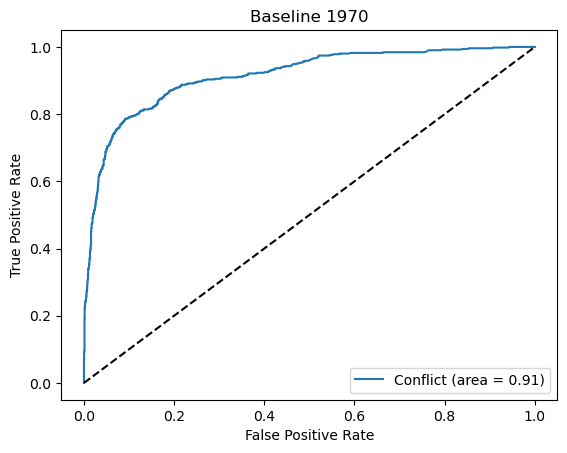

In [20]:
# For ROC AUC and ROC Curve, you need the probabilities, not the binary predictions
y_true = baseline_1970_2000_eval['either_actual']
y_prob= baseline_1970_2000_eval[['prob_minor', 'prob_major']].max(axis = 1)


# ROC AUC
roc_auc_minor = roc_auc_score(y_true, y_prob)
print(f"ROC AUC (Minor Conflict): {roc_auc_minor}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'Conflict (area = {roc_auc_minor:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline 1970')
plt.legend(loc="lower right")
plt.show()

ROC AUC (Minor Conflict): 0.9139815728278486


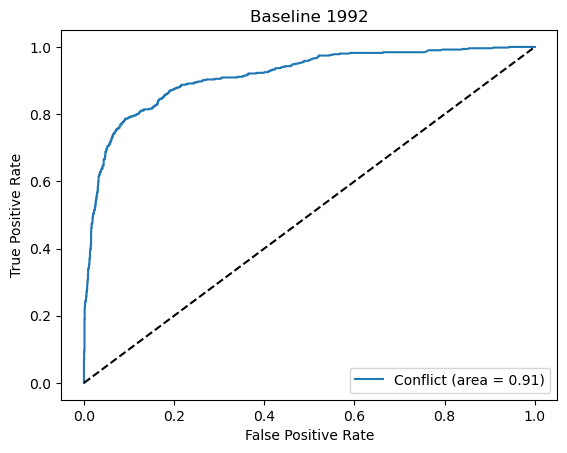

In [21]:
# For ROC AUC and ROC Curve, you need the probabilities, not the binary predictions
y_true = baseline_1992_2000_eval['either_actual']
y_prob= baseline_1992_2000_eval[['prob_minor', 'prob_major']].max(axis = 1)


# ROC AUC
roc_auc_minor = roc_auc_score(y_true, y_prob)
print(f"ROC AUC (Minor Conflict): {roc_auc_minor}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'Conflict (area = {roc_auc_minor:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline 1992')
plt.legend(loc="lower right")
plt.show()

ROC AUC (Minor Conflict): 0.6632002508361204


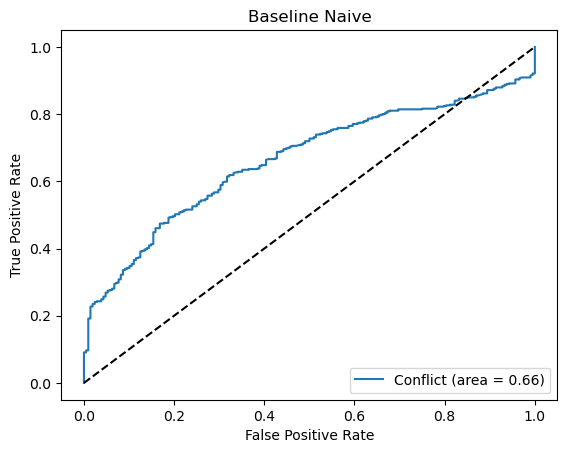

In [10]:
# For ROC AUC and ROC Curve, you need the probabilities, not the binary predictions
y_true = baseline_naive_eval['either_actual']
y_prob= baseline_naive_eval[['prob_minor', 'prob_major']].max(axis = 1)


# ROC AUC
roc_auc_minor = roc_auc_score(y_true, y_prob)
print(f"ROC AUC (Minor Conflict): {roc_auc_minor}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'Conflict (area = {roc_auc_minor:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Naive')
plt.legend(loc="lower right")
plt.show()

In [11]:
# Define your specific threshold
specific_threshold = 0.5

# Find the index of the closest threshold
closest_threshold_index = np.argmin(np.abs(thresholds - specific_threshold))

# Get the FPR and TPR for the closest threshold
specific_fpr = fpr[closest_threshold_index]
specific_tpr = tpr[closest_threshold_index]

print(f'For threshold = {specific_threshold}, FPR = {specific_fpr}, TPR = {specific_tpr}')

For threshold = 0.5, FPR = 0.07692307692307693, TPR = 0.2984189723320158


In [12]:
# # Calculate metrics for Minor Conflicts
# threshold = 0.5

# y_true = eval_df['either_actual']
# # y_pred = eval_df['combined'] > threshold 
# y_pred = (eval_df['prob_minor'] > threshold) | (eval_df['prob_major'] > threshold)

# # Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)
# print("Confusion Matrix:")
# print(cm)

# # Accuracy, Precision, Recall, F1 Score
# accuracy_minor = accuracy_score(y_true, y_pred)
# precision_minor = precision_score(y_true, y_pred)
# recall_minor = recall_score(y_true, y_pred)
# f1_minor = f1_score(y_true, y_pred)

# fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])  # FP / (TN + FP)
# tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # TP / (FN + TP)

# print(f"Accuracy: {accuracy_minor}")
# print(f"Precision: {precision_minor}")
# print(f"Recall: {recall_minor}")
# print(f"F1 Score: {f1_minor}")

# print(f"False Positive Rate: {fpr}")
# print(f"True Positive Rate: {tpr}")